<a name='0'></a>

# Deep Learning with Depthwise Separable Convolutions

[Xception](https://arxiv.org/abs/1610.02357) is a convolutional neural network architecture that was designed by Francois Chollet, Designer of Keras and the author of Deep Learning with Python book. At a high-level note, Xception uses depthwise separable convolutions and it draws inspirations from Inception modules. Also, both Xception and Inception V3 has the same number of parameters that are 22M which signifies that Xception is an efficient architecture.

In this notebook, we will learn about depthwise separable convolutions and implement it with TensorFlow. 

### What's in here: 

  * [1. Introduction](#1)
  * [2. Xception Architecture](#2)
  * [3. Implementation](#3)
  * [4. Final Notes](#4)



<a name='1'></a>

## 1. Introduction

The inarguable trend that happened(and still happening to day in 2022) in the deep learning community is that deeper networks perform better. In the previous implementations of the ConvNets architectures, we saw how almost every new architecture improved performance of the prior architectures by finding an effective way of stacking layers. A notable example of architecture for that is ResNet that used skip connections and as result, it was faster to train and converge, and all with a fair number of parameters. 

Xception is based on [InceptionV3](https://arxiv.org/abs/1512.00567) but instead of using inception modules, it uses depthwise separable convolutions. As results, it's efficient and it performs much better with the same number of parameters as Inception V3. 

Depthwise separable convolutions, also called depthwise convolutions perform independently over each channel of the input image, concatenate and apply 1x1 convolution(also called pointwise convolution) to the results. It's like learning the spatial features of each image channel before mixing their output channels together with 1x1 convolutions.

As we will see from the diagram later, the major differences between inception module and depthwise separable convolutions is that inception module uses 1x1 convolution first and perform channel-wise spatial convolution later whereas depthwise separable convolutions performs channel-wise spatial convolution first and 1x1 convolution later. Also, inception modules contain ReLU activation function whereas depthwise separable convolutions don't use non linearties. 

<a name='2'></a>
## 2. Xception Architecture

Xception is heavily built with depthwise separable convolutions. As we saw above, depthwise separable convolutions or depthwise convolutions perform spatial convolution independently on each input image channel, concatenate the results and lastly apply pointwise convolutions(1x1 convolution). As depthwise convolutions are somehow similar to inception modules, Xception or Extreme Inception is named after inception.

Below is the image of the depthwise separable convolution in comparison to the xtreme version of Inception V3 module. 





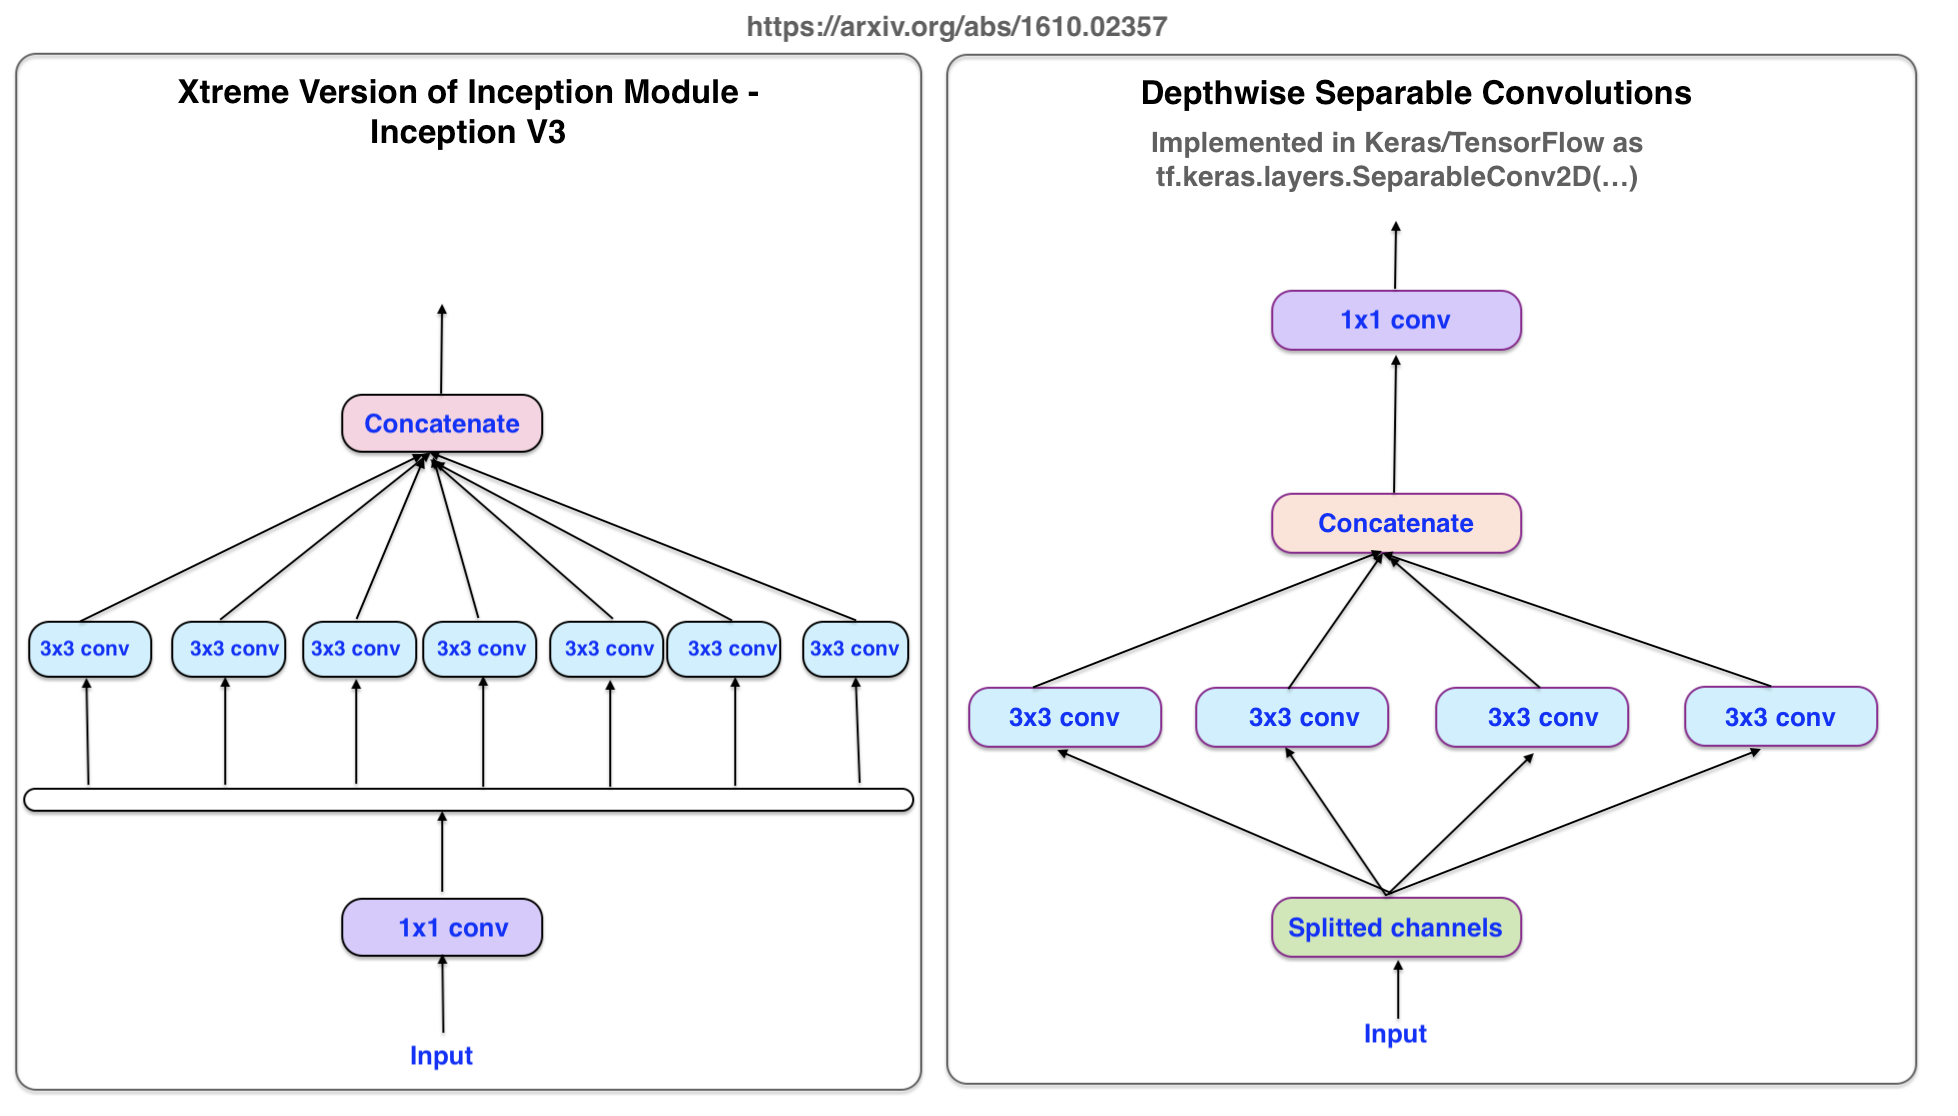

*Image: Xtreme Version of Inception Module and Depthwise Separable Convolution*

Xception architecture has 36 convolutional layers(mix of normal 2D convolutions and depthwise convolutions) which acts as a feature extractors. For classification purpose, those layers are followed by a fully connected layer (optional) and a logistic regression layer with softmax activation. Dropout layer is also optional, it was only used on ImageNet to avoid overfitting.

Those 36 convolutional layers are grouped into 36 modules. With the exception of the first and last module, all modules have residual connections. Quoting the paper, "Residual connections are clearly essential in helping with convergence, both in terms of speed and final classification performance."

Also, all normal convolutions and depthwise convolutions are followed by batch normalization layer. Below is the illustration of the whole architecture.


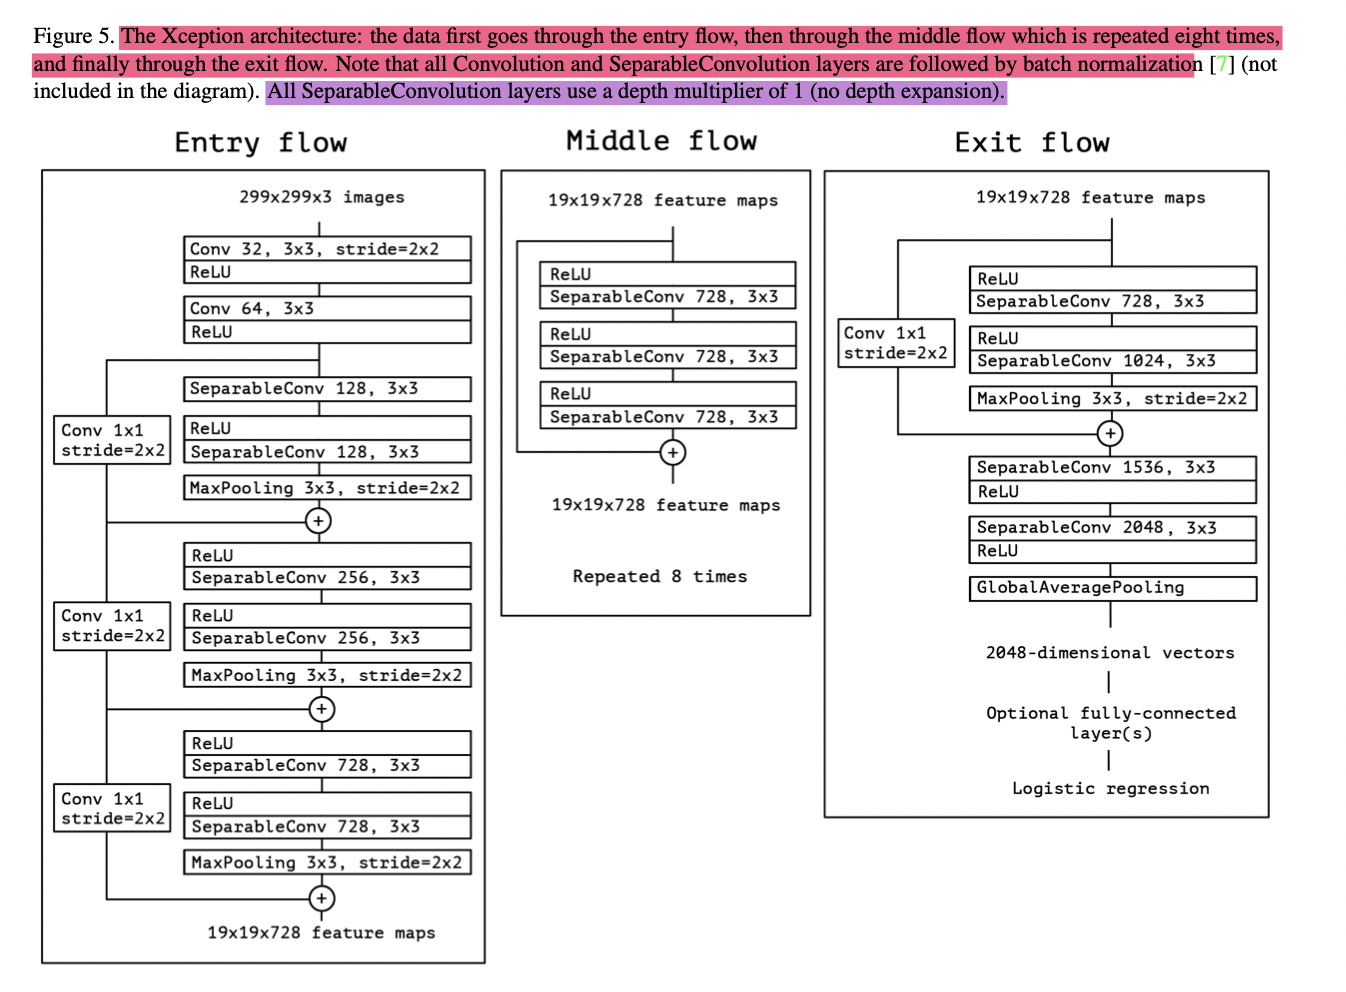

*Image: Xception, taken from the paper.*

<a name='3'></a>
## 3. Implementing Xception

#### Set up

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, utils

To implement Xception, we can simply build entry flow, middle flow, and exit and combine everything at the end. For the components of those 3 blocks, see the above table.

A few things to keep in mind is that every normal convolution and depthwise separable convolution are followed by batch normalization.

#### Entry Flow

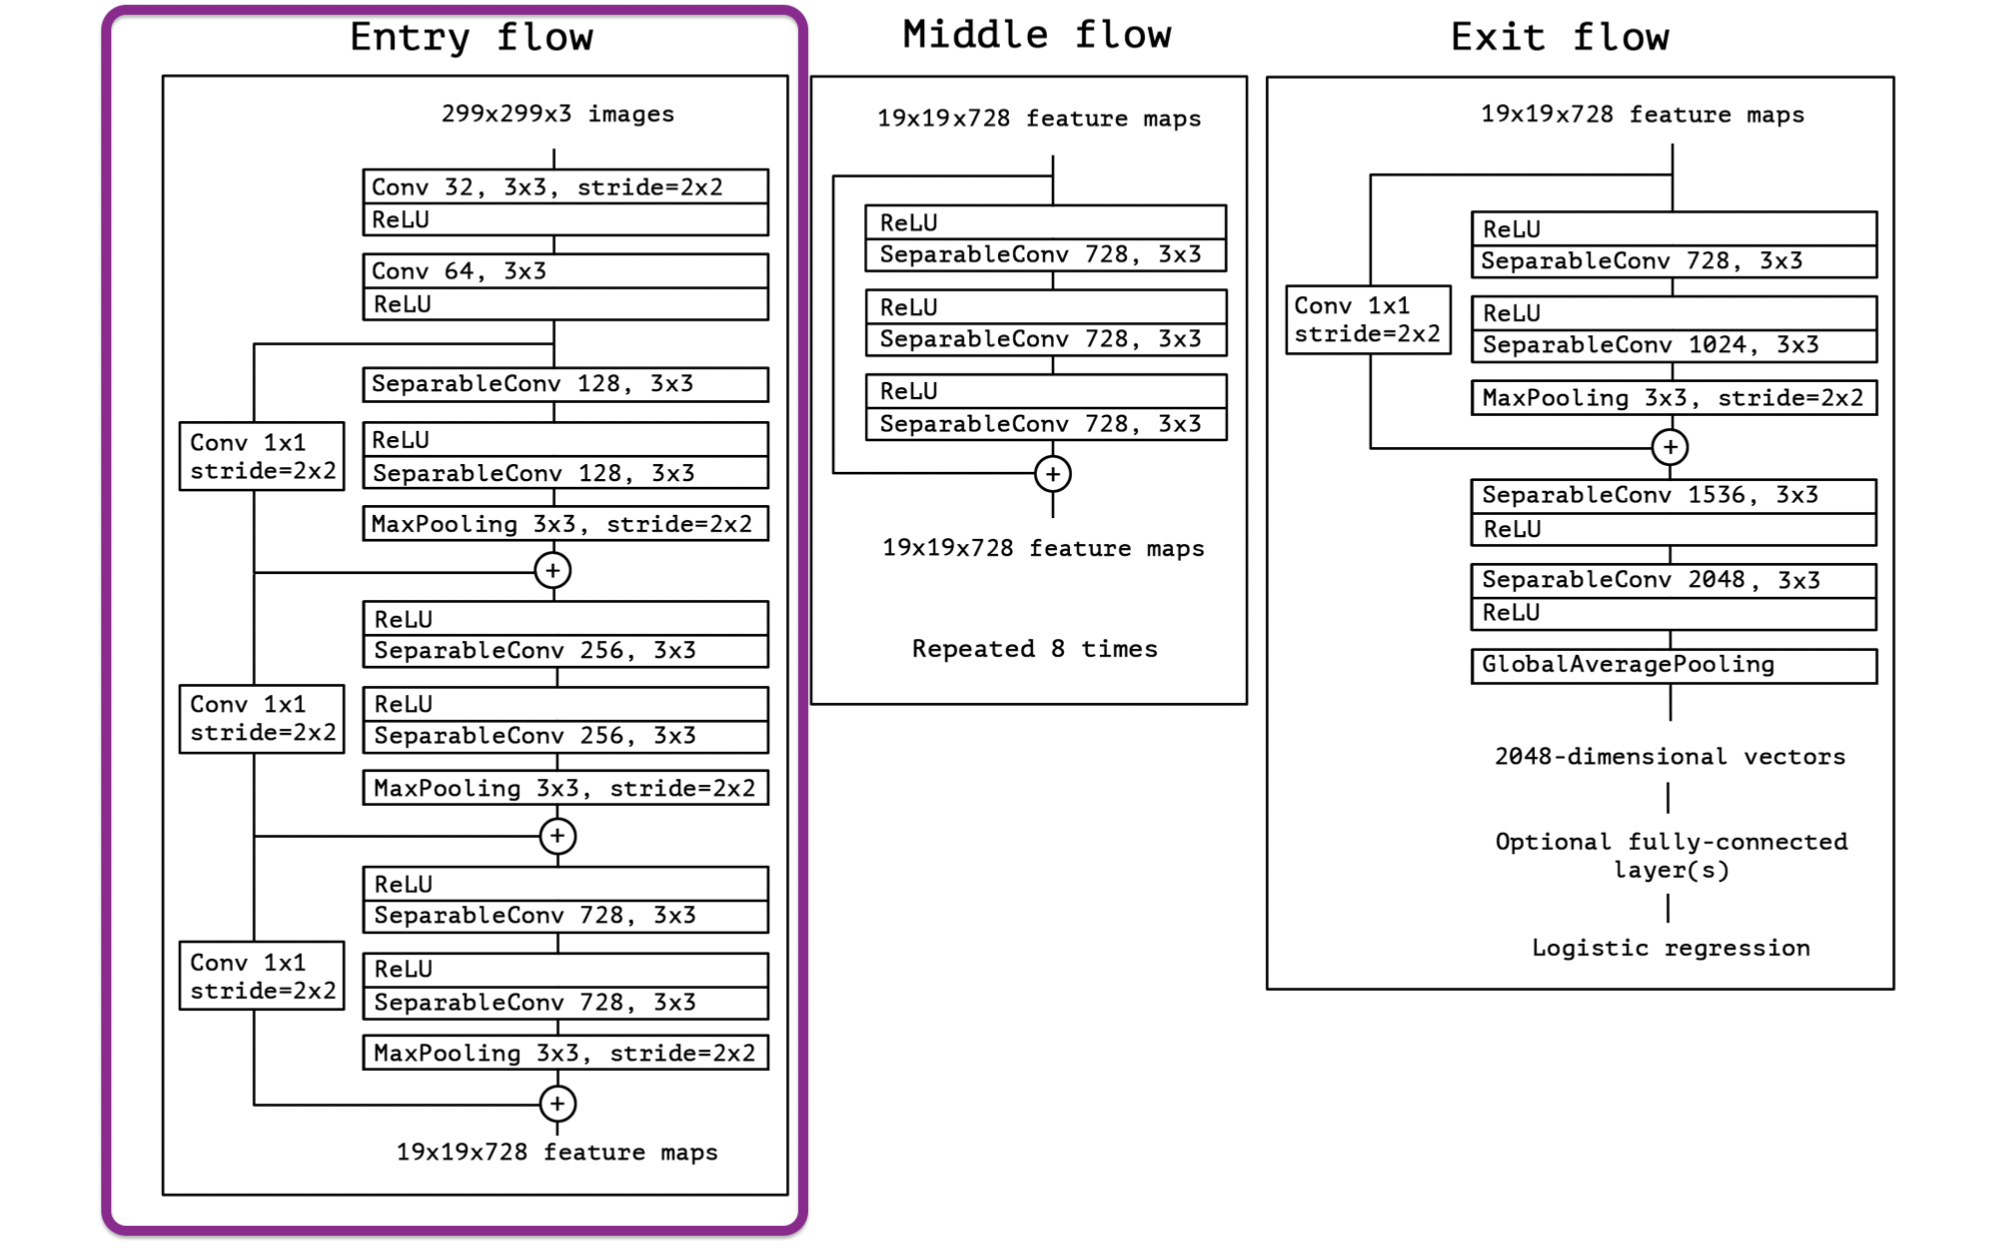

In [2]:
def entry_flow(input):
  """
  Entry flow is the first block of Xception architecture
  input: input image of shape (299, 299, 3)
  """

  x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same')(input)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  shortcut = layers.Conv2D(filters=128, kernel_size=(1,1), strides=2, padding='same')(x)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.SeparableConv2D(filters=128, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=128, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  x = layers.Add()([x, shortcut])

  shortcut = layers.Conv2D(filters=256, kernel_size=(1,1), strides=2, padding='same')(x)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=256, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=256, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  x = layers.Add()([x, shortcut])

  shortcut = layers.Conv2D(filters=728, kernel_size=(1,1), strides=2, padding='same')(x)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=728, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=728, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  output_tensor = layers.Add()([x, shortcut])

  return output_tensor

#### Middle Flow

The middle flow is a depthwise convolutions block repeated 8 times.

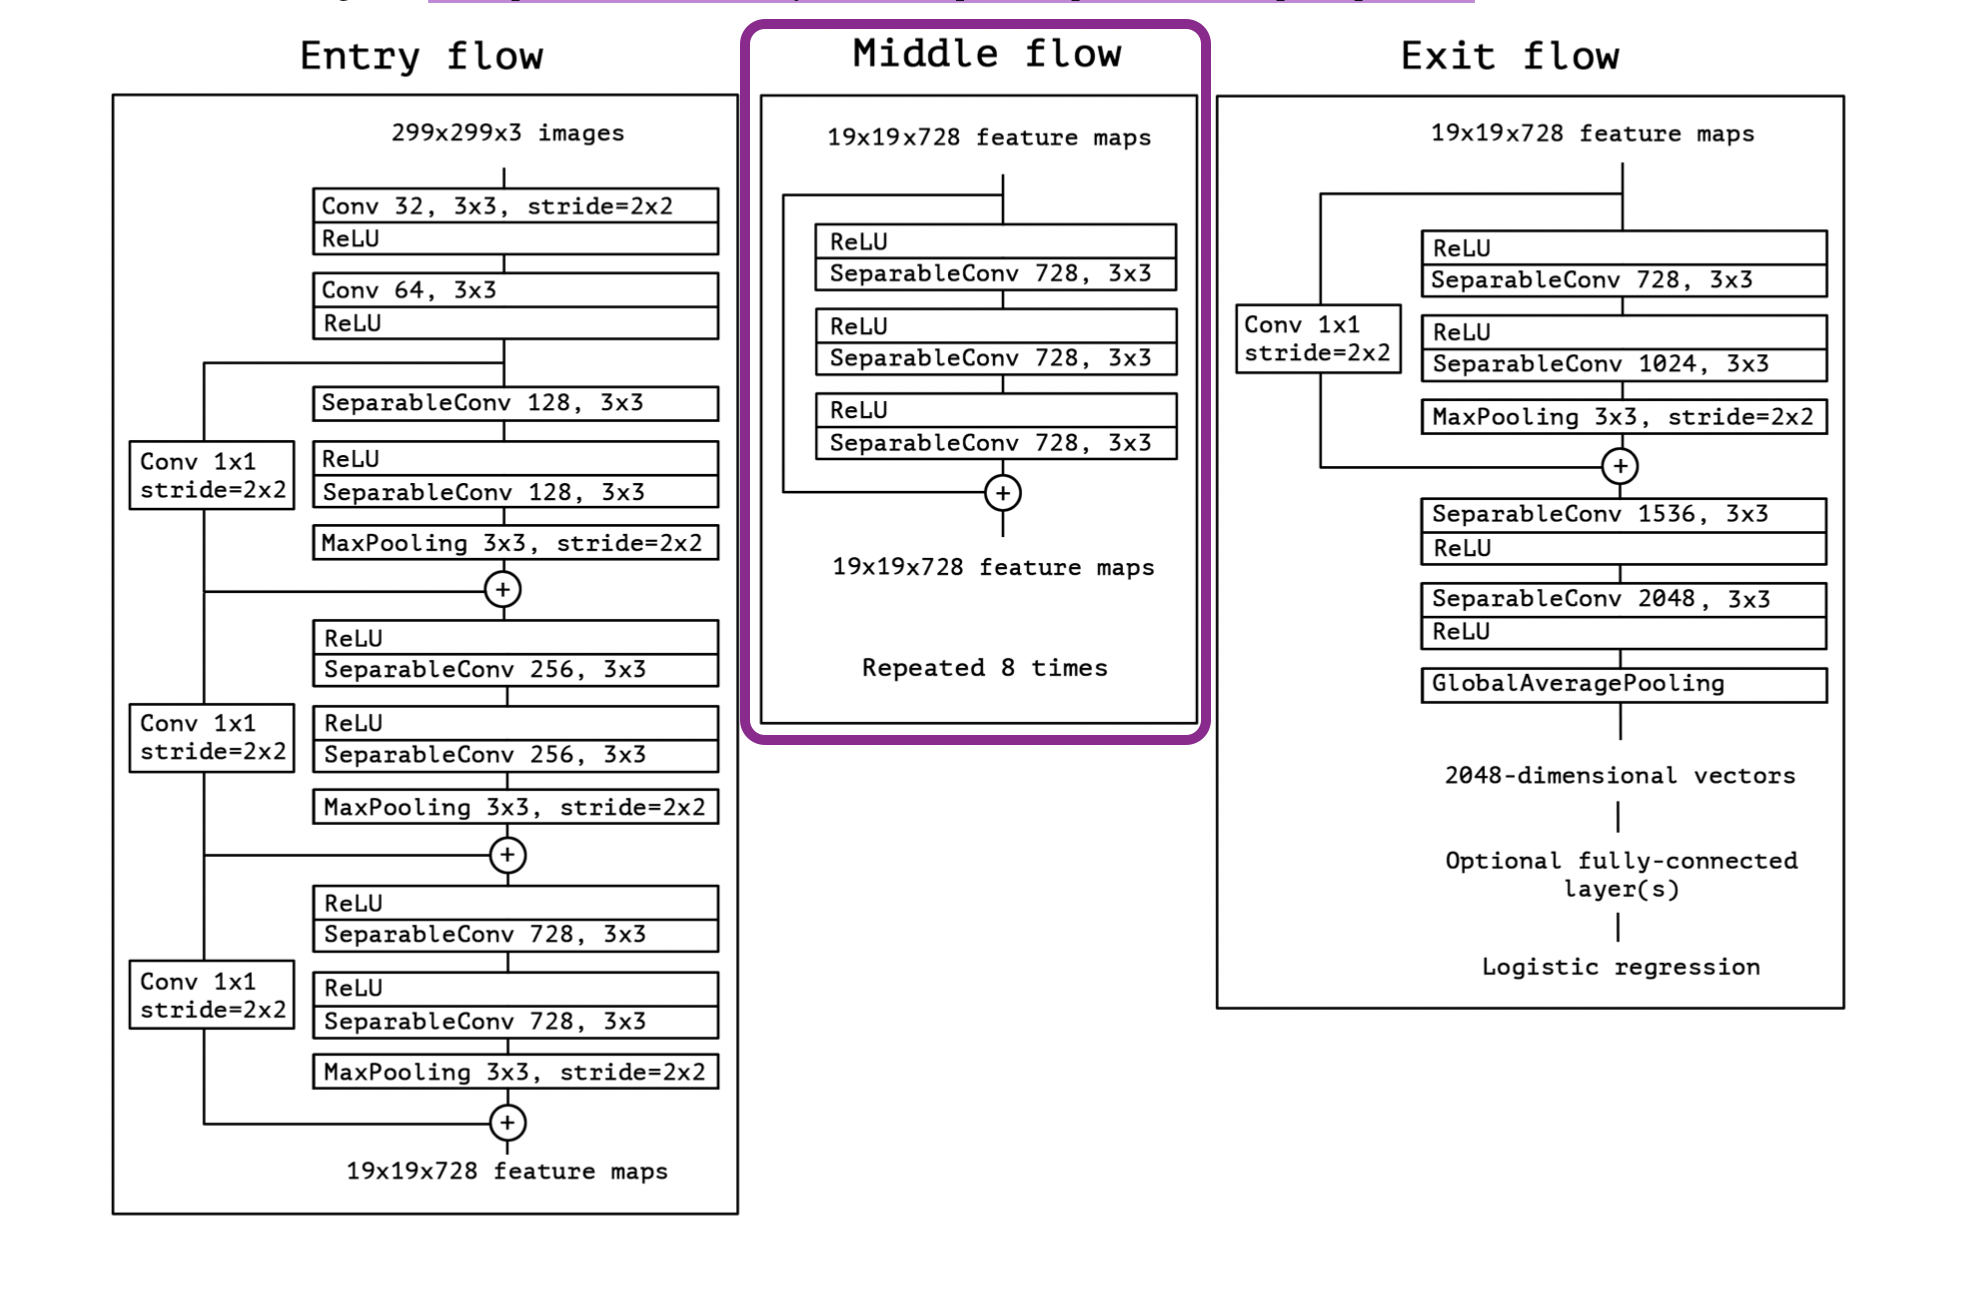

In [11]:
def middle_flow(input_tensor):
  """
  Middle flow of the Xception Architecture
  input_tensor: output tensor of the the entry flow
  Middle flow will be repeated 8 times.
  """
  shortcut = input_tensor

  x = layers.ReLU()(input_tensor)
  x = layers.SeparableConv2D(filters=728, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=728, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=728, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Add()([x, shortcut])

  return x

#### Exit Flow

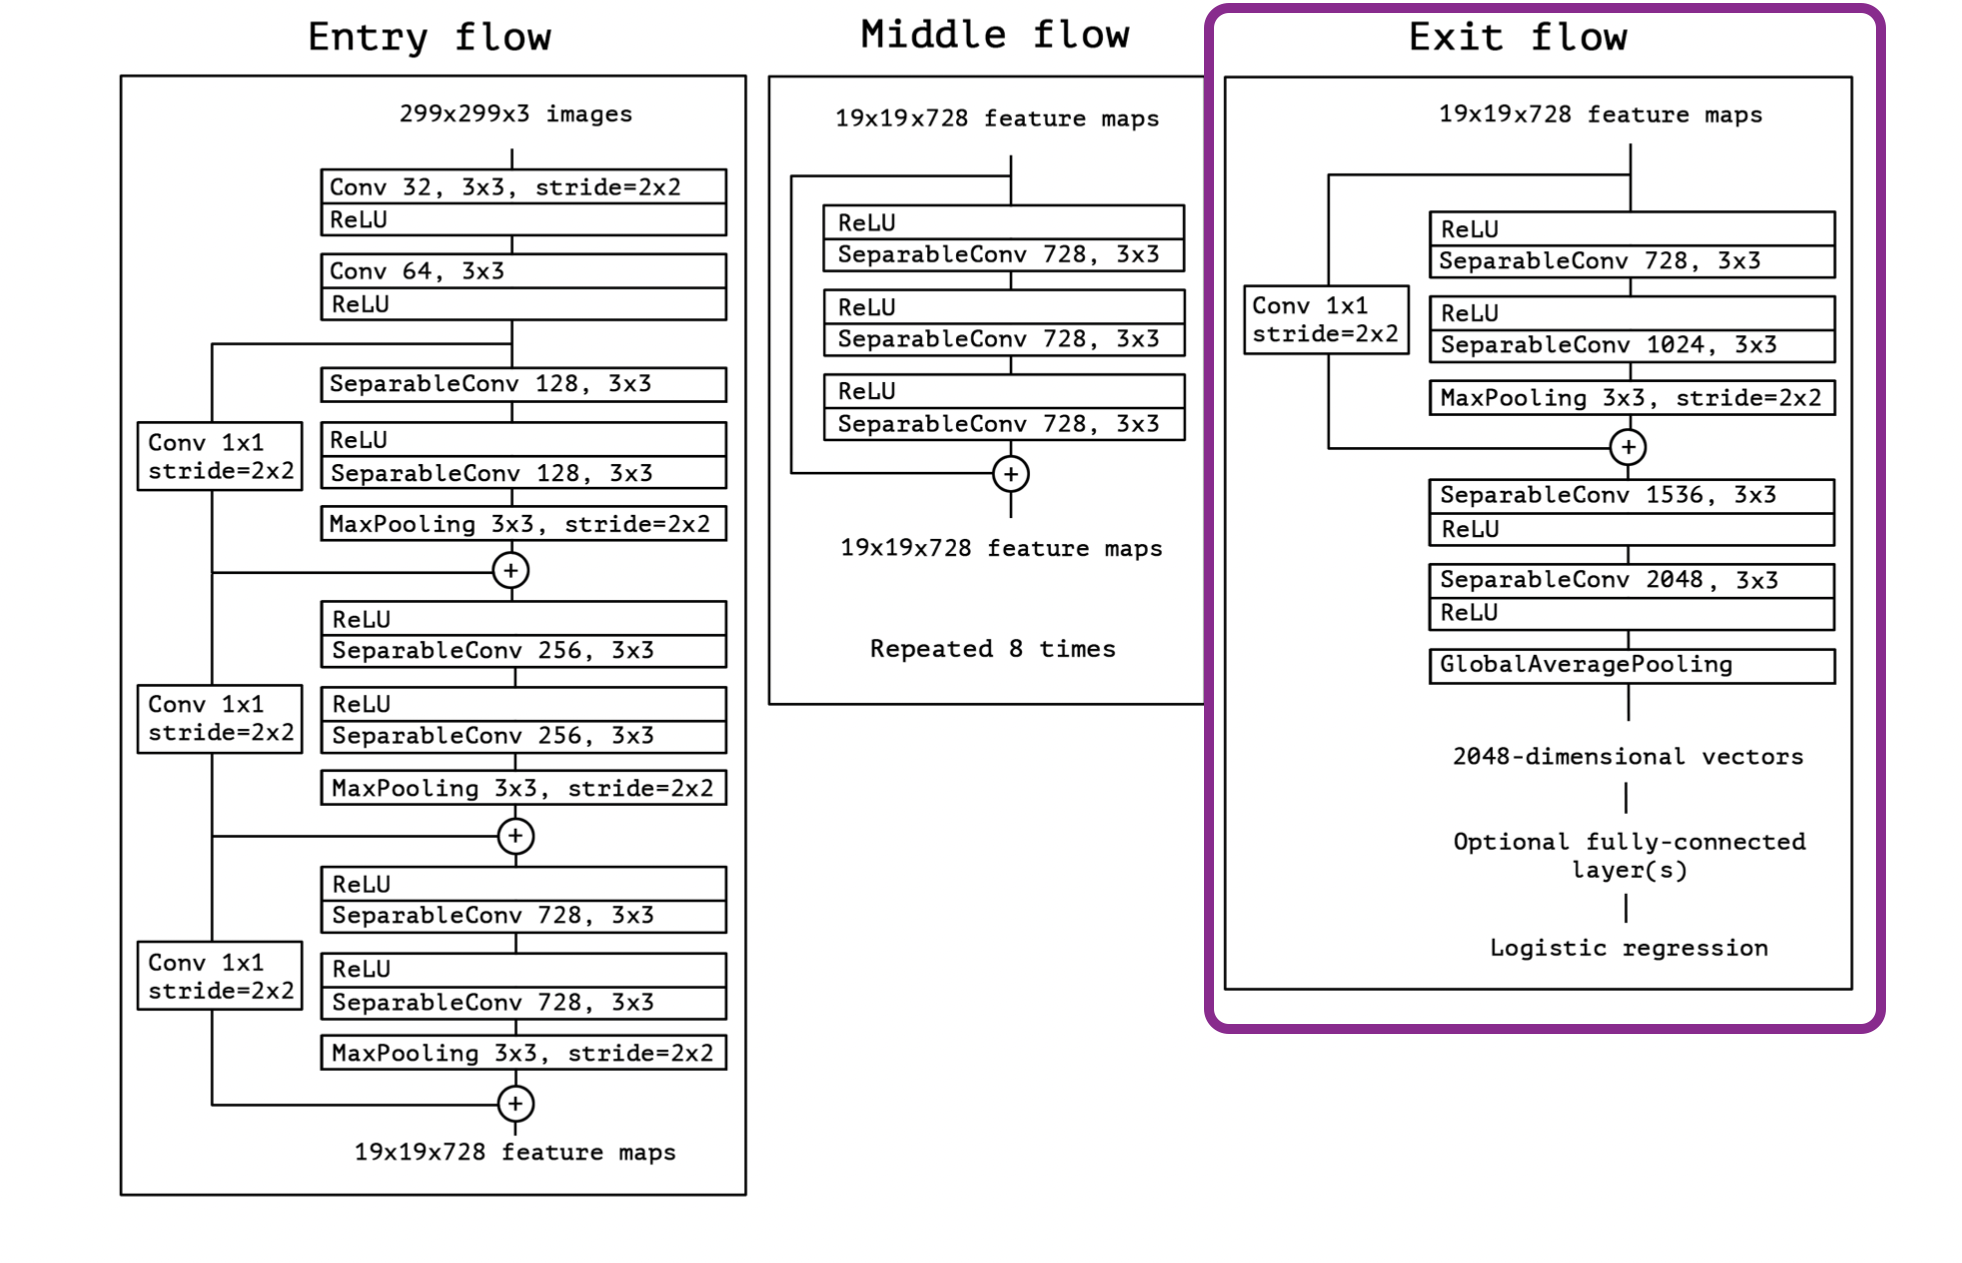

In [4]:
def exit_flow(input_tensor):
  """
  Exit flow of Xception architecture
  input_tensor: output tensor of the middle flow
  Fully connected layers before classification layer are optional
  """

  shortcut = layers.Conv2D(filters=1024, kernel_size=(1,1), strides=2, padding='same')(input_tensor)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.ReLU()(input_tensor)
  x = layers.SeparableConv2D(filters=728, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=1024, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
  x = layers.Add()([x, shortcut])

  x = layers.SeparableConv2D(filters=1536, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=2048, kernel_size=(3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.GlobalAveragePooling2D()(x)
  classifier = layers.Dense(1000, activation='softmax')(x)

  return classifier

#### Combining Entry, Middle and Exit Flows

In [12]:
input = layers.Input(shape=(299,299,3))

x = entry_flow(input)

#middle flow is repeated 8 times
for _ in range(8):
  x = middle_flow(x)

output = exit_flow(x)

xception = tf.keras.Model(input, output)

We can display the summary of the architecture that we have built.

In [13]:
xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 150, 150, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_80 (BatchN  (None, 150, 150, 32  128        ['conv2d_12[0][0]']              
 ormalization)                  )                                                           

We can also plot it. 

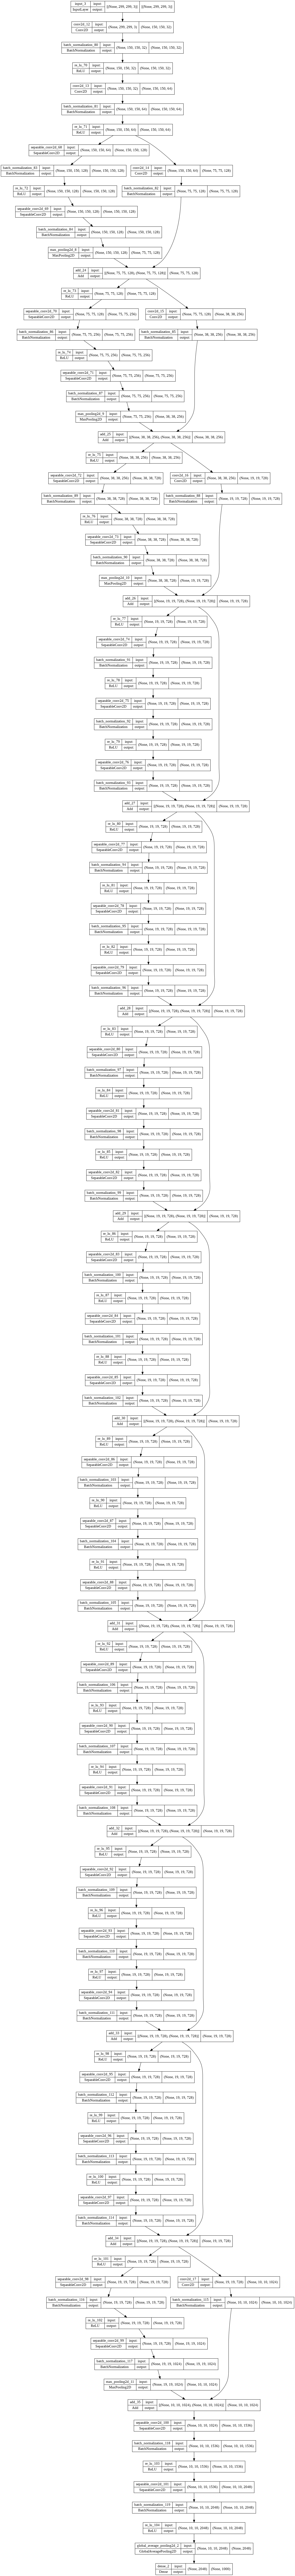

In [14]:
utils.plot_model(xception, show_shapes=True)

<a name='4'></a>
## 4. Final Notes

This was the implementation of Xception CNN architecture. Xception was very similar to [Inception V3](https://arxiv.org/abs/1512.00567) but instead of using inception modules, it used depthwise separable convolutions. As we saw, depthwise separable convolutions perform spatial convolutions(3x3 conv) on independent or separated channels, concatenate the results, and apply 1x1 convolution(pointwise convolution) to the result. We didn't have to implement our own depthwise separable convolution layer bacause it is already implemented in TensorFlow.

The paper presents other ideas recorded during the experimentation on ImageNet and JFT datasets such as comparing Inception and V3, the positive effects of the residual connections, and the absence of non-linearity in the depthwise separable convolutions. I highly recommend you read the [paper](https://arxiv.org/abs/1610.02357).



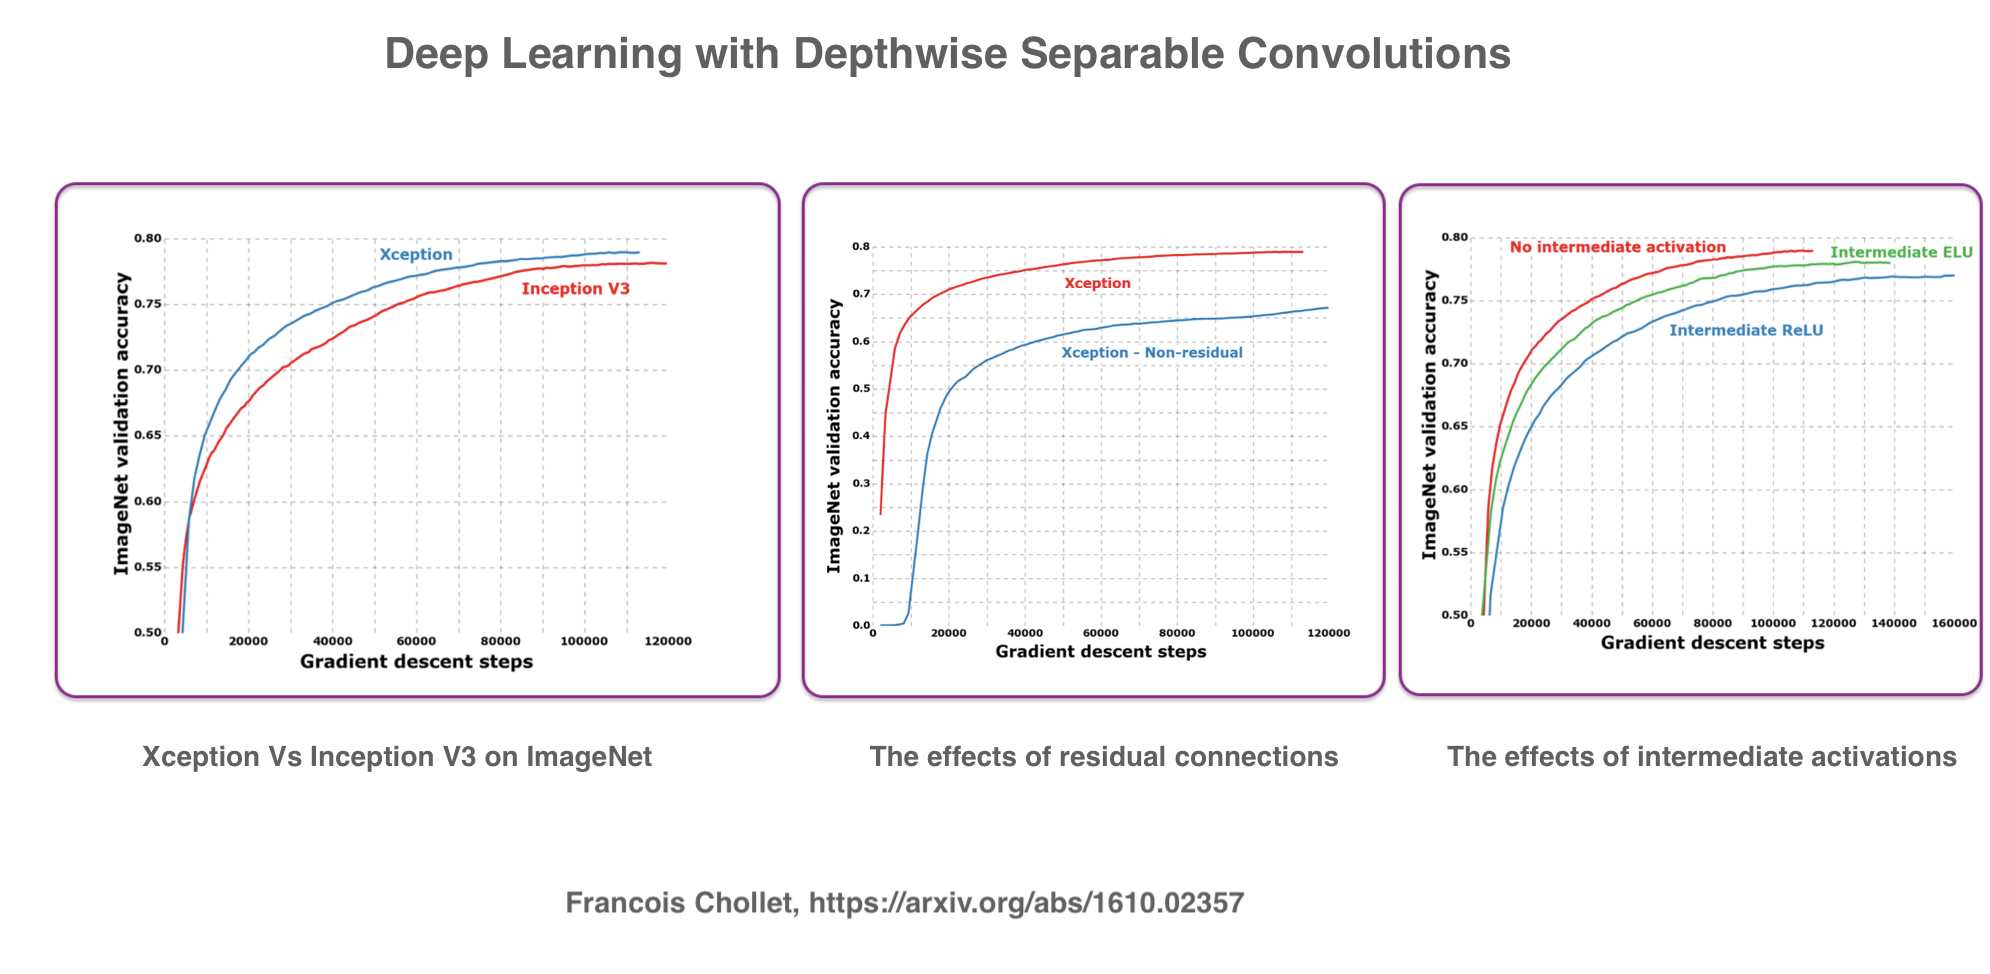

See you next time, implementing other cool CNN architecture :)

### Reference Implementations

* [Keras Applications](https://keras.io/api/applications/)
